In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Player Retention A/B Testing

## Project Overview:

This project is based on and uses data from the DataCamp project [A/B Testing with Cookie Cat](https://projects.datacamp.com/projects/184). 

### Excerpt from the DataCamp Description of the Game
Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level. It also features singing cats. 

As players progress through the game levels, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the critical purpose of giving players an enforced break from playing the game, hopefully resulting in the player's enjoyment of the game being increased and prolonged.

### Project Goal

This project aims to find if there is a statistically significant difference in the percentage of player retention by setting the gate at level 30 or 40. I will examine the one-day and seven-day retention rates using two different types of A/B testing techniques. 

### Data Dictionary

The data is from 90,189 players that installed the game while the AB-test was running. The variables are:

- userid - a unique number that identifies each player.
- version - whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
- sum_gamerounds - the number of game rounds played by the player during the first 14 days after install.
- retention_1 - did the player come back and play 1 day after installing?
- retention_7 - did the player come back and play 7 days after installing?

## Data Loading and Cleaning

In [2]:
df = pd.read_csv('cookie_cats.csv')

In [3]:
df.shape

(90189, 5)

In [4]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [6]:
df.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [7]:
df['userid'].nunique() == df.shape[0]

True

In [8]:
df.pivot_table(index='version', aggfunc={'userid':'count'})

,userid
version,
gate_30,44700
gate_40,45489


The data is consistent with what was outlined in the data dictionary. There are no null values, and all features appear to be in the correct data type. In addition, all users are unique, and there are roughly the same amount of users in each game version.

In [9]:
discrepancies = df[(df['retention_1'] == False) & (df['retention_7'] == True)]
discrepancies

,userid,version,sum_gamerounds,retention_1,retention_7
10,1842,gate_40,3,False,True
23,2729,gate_30,105,False,True
90,8788,gate_30,19,False,True
102,10200,gate_40,106,False,True
143,13429,gate_30,60,False,True
...,...,...,...,...,...
89967,9975174,gate_30,26,False,True
90044,9982773,gate_30,1,False,True
90046,9983040,gate_30,137,False,True
90156,9996093,gate_40,23,False,True


In [10]:
discrepancies.pivot_table(index='version', aggfunc={'userid':'count'}) 

,userid
version,
gate_30,1826
gate_40,1773


In [11]:
df.drop(index=discrepancies.index, axis=0, inplace=True)

In [12]:
df.shape

(86590, 5)

There are some discrepancies in the data; logically, it's impossible not to return after the first day and return after the seventh. This discrepancy only accounts for roughly 4% of the data and is roughly the same in both versions. Therefore, I will discard these samples. The resulting data frame consists of 86590 samples.

## Exploratory Data Analysis

### Game Rounds Played

In [13]:
def ecdf(col):
    x = sorted(col)
    y = np.arange(1, len(col)+1) / len(col)
    return x, y

In [14]:
df['sum_gamerounds'].describe()

count    86590.000000
mean        50.369546
std        102.924378
min          0.000000
25%          5.000000
50%         16.000000
75%         49.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

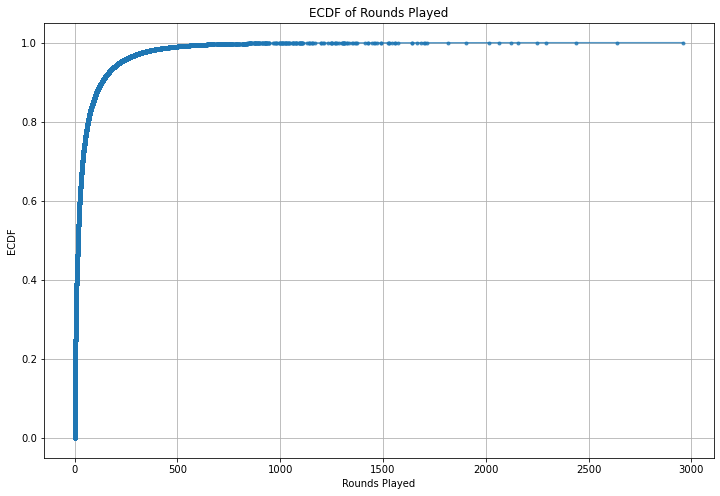

In [15]:
x, y = ecdf(df['sum_gamerounds'])

fig, ax = plt.subplots(figsize=(12,8))
plt.plot(x, y, marker='.', linestyle=None, alpha=0.75)
plt.title("ECDF of Rounds Played")
plt.xlabel('Rounds Played')
plt.ylabel('ECDF')
plt.grid()
plt.show()

In [16]:
rounds_outliers = df[df['sum_gamerounds'] > 500]
rounds_outliers.groupby('version').agg({'userid':'count', 'retention_1':np.mean, 'retention_7':np.mean})

,userid,retention_1,retention_7
version,,,
gate_30,417,0.995204,0.947242
gate_40,420,0.997619,0.961905


In [17]:
df.drop(index=rounds_outliers.index, axis=0, inplace=True)

Some players clearly love the game! They have played over 500 rounds during the duration of this test, but they are the outliers and will be dropped from the test. 

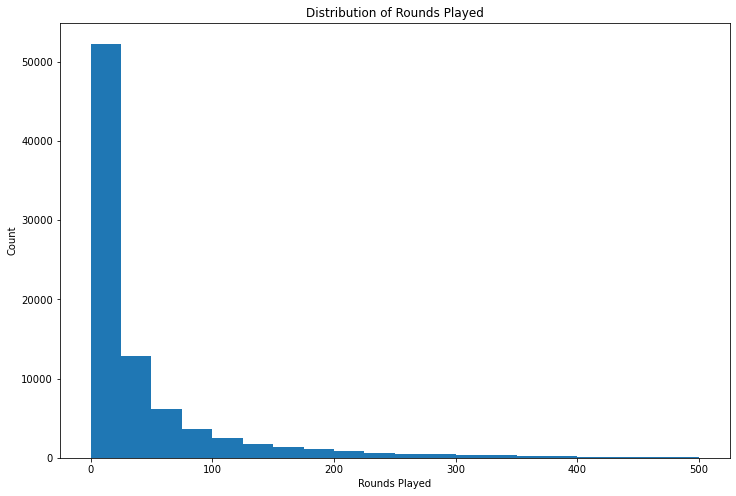

In [18]:
fig, ax = plt.subplots(figsize=(12,8))
plt.hist(df['sum_gamerounds'], bins=20)
plt.title('Distribution of Rounds Played')
plt.xlabel('Rounds Played')
plt.ylabel('Count')
plt.show()

The distribution of the rounds played data is right-skewed. The majority of the players stopped playing at roughly round 50; the ECDF graph will show a clearer picture.

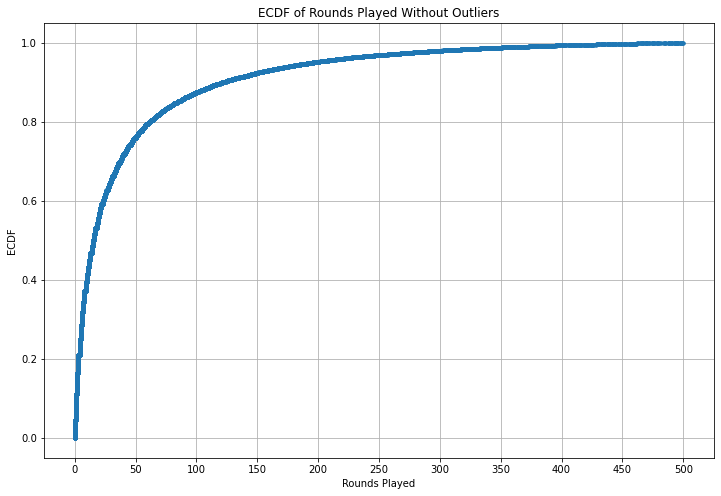

In [19]:
x, y = ecdf(df['sum_gamerounds'])

fig, ax = plt.subplots(figsize=(12,8))
plt.plot(x, y, marker='.', linestyle='None', alpha=0.75)
plt.title("ECDF of Rounds Played Without Outliers")
plt.xlabel('Rounds Played')
plt.xticks(np.arange(0,501,50),np.arange(0,501,50))
plt.ylabel('ECDF')
plt.grid()

In [20]:
len(df[df['sum_gamerounds'] <= 1]) / len(df) * 100

11.049176122118176

The ECDF graph shows that roughly 60% of the players stopped playing at round 30. This percentage increases to roughly 75% at round 50. There are also around 11% of users that downloaded the game but played one or less rounds. 

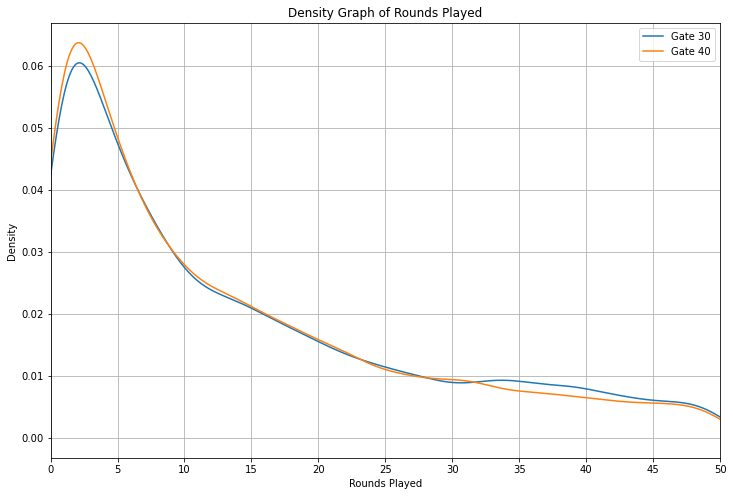

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
df.loc[(df['version'] == 'gate_30') & (df['sum_gamerounds'] <= 50), 'sum_gamerounds'].plot(kind='kde', label='Gate 30')
df.loc[(df['version'] == 'gate_40') & (df['sum_gamerounds'] <= 50), 'sum_gamerounds'].plot(kind='kde', label='Gate 40')
plt.title('Density Graph of Rounds Played')
plt.xlabel('Rounds Played')
plt.xticks(np.arange(0,51,5), np.arange(0,51,5))
plt.xlim(0,50)
plt.grid()
plt.legend()
plt.show()

When comparing the user's round played density of the two versions, some differences emerge. For example, compared to the gate 30 version, the gate 40 version has more players that only play less than five rounds. Then, the two versions follow the same distribution until the thirty rounds played mark. Then, it is interesting to see that the proportion of players that reached round forty is higher in gate 30 than in the gate 40 version.

In [22]:
r1_avg_rounds = df.groupby(['version', 'retention_1']).sum_gamerounds.mean()
r1_avg_rounds

version  retention_1
gate_30  False          11.741527
         True           81.103675
gate_40  False          11.890617
         True           81.418426
Name: sum_gamerounds, dtype: float64

In [23]:
r7_avg_rounds = df.groupby(['version', 'retention_7']).sum_gamerounds.mean()
r7_avg_rounds

version  retention_7
gate_30  False           25.418537
         True           149.623468
gate_40  False           25.543690
         True           153.137004
Name: sum_gamerounds, dtype: float64

The average round played for the seven-day retention group is significantly higher than the one-day ground. This observation makes sense as the more days a user plays, the higher level they should reach. In the one-day retention group, both versions have similar results. However, in the seven-day retention group, players in the gate 40 version average about 3.5 levels higher compared to the other.

## Retention Rates

In [24]:
df.groupby('version')[['retention_1', 'retention_7']].mean() * 100

,retention_1,retention_7
version,,
gate_30,46.209106,14.793791
gate_40,45.500739,14.093681


The initial observation shows that the 40-gate version has a roughly 0.7% lower retention rate in one and seven-day metrics. The seven-day retention rate is lower than the one-day; this makes sense as many players download the game to see if they enjoy it.

In [25]:
def retention_perc(day):
    # args(int): 1 or 7 for retention group
    retention_dict = {}
    col = 'retention_{}'.format(day)
    for i in np.arange(30,51,10):
        retention_dict[i] = df[df['sum_gamerounds'] <= i].groupby('version')[col].mean() * 100
    result_df = pd.DataFrame(retention_dict).T
    result_df['relative_percentage_diff'] = (result_df['gate_30'] - result_df['gate_40'])  / result_df['gate_40'] * 100
    return result_df

In [26]:
retention_perc(1)

version,gate_30,gate_40,relative_percentage_diff
30,24.838208,24.608485,0.93351
40,29.050846,28.319495,2.58250
50,32.085677,30.972079,3.59549


In [27]:
retention_perc(7)

version,gate_30,gate_40,relative_percentage_diff
30,1.999349,1.765757,13.229017
40,2.832073,2.535882,11.679988
50,3.712240,3.251414,14.173082


When comparing the one-day retention rate of the different levels played, both versions have similar proportions up to round 30, with the gate 30 version slightly higher. However, when looking at players that reached level 40 or 50, the gate 30 version has a 0.7% and 1.5% absolute increase in retention rate. This increase equates to a 2.58% and 3.6% relative increase.

The 30 gate version is higher in the seven-day metric, and the results are more pronounced. There is over a 10% relative difference between the two versions in all three measurements.

# A/B Test

I will use two different A/B testing methods to determine if the two different versions are statistically significant. 

### Hypothesis Test

- Define testing parameters
- Determine if the samples meet the normal condition
- Calculate confidence interval
- Calculate P-Value
- Determine if $H_0$ can be rejected

#### Testing Parameters

- Control = Version Gate_30
- Treatment = Version Gate_40

$H_0$: $p_c$ = $p_t$

$H_a$: $p_c$ $\neq$ $p_t$

$alpha$ = 0.05

In [28]:
df['group'] = np.where(df['version'] == 'gate_30', 'control', 'treatment')
df

,userid,version,sum_gamerounds,retention_1,retention_7,group
0,116,gate_30,3,False,False,control
1,337,gate_30,38,True,False,control
2,377,gate_40,165,True,False,treatment
3,483,gate_40,1,False,False,treatment
4,488,gate_40,179,True,True,treatment
...,...,...,...,...,...,...
90184,9999441,gate_40,97,True,False,treatment
90185,9999479,gate_40,30,False,False,treatment
90186,9999710,gate_30,28,True,False,control
90187,9999768,gate_40,51,True,False,treatment


In [29]:
def check_normal(df, metric):
    '''
    tests if the sample is normal, 
    criteria: if expected success & failure are both at least 10 for each group
    args:
        df: dataframe to test
        metric: retention_1 or retention_7
    return:
        bool: whether the sample meets the normal condition
    '''
    control = df.loc[df['group'] == 'control', metric]
    treatment = df.loc[df['group'] == 'treatment', metric]
    
    c_prob_success = control.mean()
    c_prob_failure = 1 - c_prob_success
    
    c_es = control.sum() * c_prob_success
    c_ef = (control == False).sum() * c_prob_failure
    
    t_prob_success = treatment.mean()
    t_prob_failure = 1 - t_prob_success
    
    t_es = treatment.sum() * t_prob_success
    t_ef = (treatment == False).sum() * t_prob_failure
    
    
    if c_es >= 10 and c_ef >= 10 and t_es >= 10 and t_ef >= 10:
        return 'The samples are normal!'
    else:
        return 'The samples are NOT normal!'

In [30]:
def confidence_int(df, metric, alpha=0.05, n_sides=2):
    '''
    calculates lower and upper bound of confidence interval using z-stats
    args:
        df
        metric: retention_1 or retention_7
        alpha(float): significance level, default 0.05
        n_sides(int): 1 or 2 depending on the num sides of test
    return:
        tuple: lower and upper bound of confidence interval
    '''
    from scipy import stats
    
    control = df.loc[df['group'] == 'control', metric]
    treatment = df.loc[df['group'] == 'treatment', metric]
    
    z_crit = stats.norm.ppf(1-alpha/n_sides)
    
    control_p = control.mean()
    control_sigma = control_p * (1-control_p) / len(control)
    treatment_p = treatment.mean()
    treatment_sigma = treatment_p * (1-treatment_p) / len(treatment)
    
    effect_size = control.mean() - treatment.mean()
    delta = np.sqrt(control_sigma + treatment_sigma)
    
    lower_bound = effect_size - z_crit * delta
    upper_bound = effect_size + z_crit * delta
    
    return (lower_bound, upper_bound)

In [31]:
def two_proportion_z_test(df, metric, alpha=0.05, n_sides=2):
    '''
    Calculates the P-Value using Z-statistics,
    this function assumes null hypothesis is the two sample proportions are equal
    args:
        df
        metric: retention_1 or retention_7
        alpha(float): significance level, default 0.05
        n_sides(int): 1 or 2 depending on the num sides of test
    return:
        dictionary of Z-Score, P-Value and if H0 is rejected
    '''
    
    from scipy import stats
    control = df.loc[df['group'] == 'control', metric]
    treatment = df.loc[df['group'] == 'treatment', metric]
    
    effect_size = control.mean() - treatment.mean()
    p_given_h0 = (control.sum() + treatment.sum()) / (len(control) + len(treatment))
    std_given_h0 = np.sqrt(p_given_h0*(1-p_given_h0)/len(control) + p_given_h0*(1-p_given_h0)/len(treatment))
    
    z_score = effect_size / std_given_h0
    p_value = stats.norm.sf(z_score)*2
    
    if p_value < alpha:
        result = 'Reject H0'
    else:
        result = 'Unable to reject H0'
    result_dict = {'z_score':z_score,
                  'p_value':p_value,
                  'result':result}
    
    return result_dict

## One-day Retention

In [32]:
#Normal Test
check_normal(df, 'retention_1')

'The samples are normal!'

In [33]:
#Confidence interval
confidence_int(df, 'retention_1')

(0.00041347553664948435, 0.013753856165295467)

In [34]:
#Z Proportion Test
two_proportion_z_test(df, 'retention_1')

{'z_score': 2.081430847489595,
 'p_value': 0.037394487605666056,
 'result': 'Reject H0'}

The samples for the one-day retention metric passed the normal test. Therefore, I can conclude with 95% confidence that the actual population difference between the treatment and control groups is between 0.0004 and 0.0138. Additionally, the Z-Test resulted in a Z-Score of over 2, given that the null hypothesis is true, which equates to a P-Value of 0.03. This result allowed me to reject the null hypothesis and conclude a statistically significant difference between the gate 30 and gate 40 player retention rates.

## Seven-day Retention

In [35]:
#Normal Test
check_normal(df, 'retention_7')

'The samples are normal!'

In [36]:
#Confidence interval
confidence_int(df, 'retention_7')

(0.0022950065277694293, 0.011707206589172124)

In [37]:
#Z Proportion Test
two_proportion_z_test(df, 'retention_7')

{'z_score': 2.9162025966385587,
 'p_value': 0.0035432034137403952,
 'result': 'Reject H0'}

The result for the seven-day retention metric is similar to the one-day retention. This sample also passed the normal test, and I conclude with 95% confidence that the actual difference in the proportion is between 0.002 and 0.0117. The Z-test resulted in a Z-Score of 2.916 with a P-Value of 0.004. This result also allowed me to reject the null hypothesis and determine a statistically significant difference between the two gates' retention rates.

## Bootstrap Permutations

This technique repeatedly samples each group with replacements, then mixes thegroups with a random permutation. Next, I slice them to the length of the original groups and calculate the mean of each group. Lastly, I find the difference between the means and store them in an array. Finally, I find the probability of occurrences that are at least as extreme as the effect size of the original data. This number will be the P-Value of this test, and I will compare it to the alpha stated in the hypothesis.

In [38]:
def permutation(df1, df2):
    temp_df = np.concatenate((df1, df2))
    temp_df = np.random.permutation(temp_df)
    
    temp_df1 = temp_df[:len(df1)]
    temp_df2 = temp_df[len(df1):]
    
    return temp_df1, temp_df2

In [39]:
def bootstrap_permutation_rep(df, metric, n, func):
    
    control = df.loc[df['group'] == 'control', metric]
    treatment = df.loc[df['group'] == 'treatment', metric]
    
    result_array = np.zeros(n)
    
    for i in range(n):
        bs_control = np.random.choice(control, replace=True, size=len(control))
        bs_treat = np.random.choice(treatment, replace=True, size=len(treatment))
        bs1, bs2 = permutation(bs_control, bs_treat)
        
        result_array[i] = func(bs1) - func(bs2)
    return result_array

### One-day Retention

In [40]:
bootstrap_reps_1day = bootstrap_permutation_rep(df, 'retention_1', 10000, np.mean)

In [51]:
effect_size_1d = df.loc[df['group'] == 'control', 'retention_1'].mean() - df.loc[df['group'] == 'treatment', 'retention_1'].mean()
effect_size_1d

0.007083665850972476

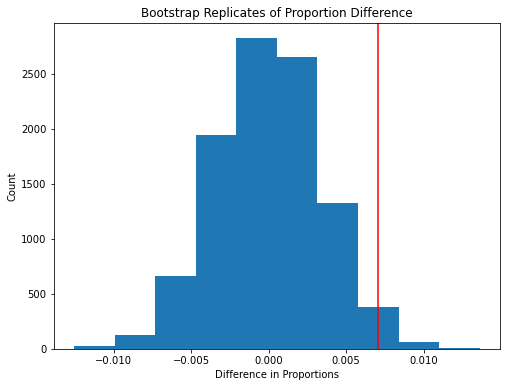

In [43]:
fig, ax = plt.subplots(figsize=(8,6))
plt.hist(bootstrap_reps_1day)
plt.title('Bootstrap Replicates of Proportion Difference')
plt.xlabel('Difference in Proportions')
plt.ylabel('Count')
plt.axvline(effect_size_1d, color='red')
plt.show()

In [45]:
p_value_1d = (abs(bootstrap_reps_1day) > effect_size_1d).sum() / len(bootstrap_reps_1day)
p_value_1d

0.0382

The result for the bootstrap test is the same as the Z-Test; there is only a 3.6% chance of getting a difference at least as extreme as the one observed in this data. Therefore, I can reject the null hypothesis and determine a statistically significant difference between the two gates.

### Seven-day Retention

In [46]:
bootstrap_reps_7day = bootstrap_permutation_rep(df, 'retention_7', 10000, np.mean)

In [52]:
effect_size_7d = df.loc[df['group'] == 'control', 'retention_7'].mean() - df.loc[df['group'] == 'treatment', 'retention_7'].mean()
effect_size_7d

0.0070011065584707766

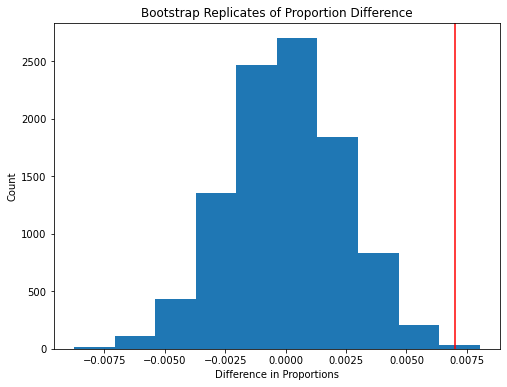

In [49]:
fig, ax = plt.subplots(figsize=(8,6))
plt.hist(bootstrap_reps_7day)
plt.title('Bootstrap Replicates of Proportion Difference')
plt.xlabel('Difference in Proportions')
plt.ylabel('Count')
plt.axvline(effect_size_7d, color='red')
plt.show()

In [50]:
p_value_7d = (abs(bootstrap_reps_7day) > effect_size_7d).sum() / len(bootstrap_reps_7day)
p_value_7d

0.0038

Similar to the one-day retention rates, there is also a statistically significant difference between the different groups in the seven-day retentions. The resulting P-Value is 0.004, which means there is only a 0.4% chance of getting a difference as extreme as the observed effect size. Therefore, I can reject the null hypothesis for this metric as well.

## Result and Recommendations

This project aimed to determine if the retention rates in the one-day and seven-day rates are statistically significant when comparing the two different versions. The gate-30 version has a roughly 0.7% higher retention rate in both metrics. Additionally, the analysis shows a higher proportion of players reached at least level 40 in the gate-30 version. The retention rate also increases as players reach a higher level; this makes sense, as the ones who enjoy the game will likely come back to play.

The results from both the Z-Statistic test and the Bootstrap permutation test conclude that there is a statistically significant difference in the retention rate in both metrics. 

#### Result Summary for One-Day Retention

The 95% confidence interval for the difference in the population retention rate in the one-day retention is between 0.0004 and 0.0138. The effect size observed in this dataset was 0.007, within the range of this interval. The Z-Test for the one-day retention metric resulted in a P-Value of 0.037. At the same time, the bootstrap test yielded a similar P-Value of 0.0382. Both of these results are below the significance level set at 0.05. Therefore I can reject the null hypothesis and conclude that there is a statistical difference between these versions.

#### Result Summary for Seven-Day Retention

The results for the seven-day metric are that there is also a statistically significant difference between the retention rates between the versions. This metric's 95% confidence interval is between 0.002 and 0.0117; the effect size observed in this data was 0.007 within the interval. Additionally, the P-Value for the Z-test and the bootstrap test were 0.0035 and 0.0038, respectively. Therefore, I can also reject the null hypothesis and conclude there is a statistically significant difference.

#### Recommendation

I recommend proceeding with the gate-30 version; this resulted in a higher retention rate in both metrics. Additionally, there is a noticeable increase in the retention rate in both metrics when players reach level 50. The organization should explore ways to incentivize players to reach level 50, then repeat this test.
